In [102]:
import argparse
import time
import os
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import bottleneck as bn
import adabound
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from scipy import sparse
from copy import deepcopy

# Multi-DAE & Multi-VAE with MovieLens20M
Multi-DAE와 Multi-VAE를 사용하여 MovieLens20M 데이터를 기반으로 한 유저별 영화 예측

In [103]:
## 각종 파라미터 세팅
parser = argparse.ArgumentParser(description='PyTorch Variational Autoencoders for Collaborative Filtering')


parser.add_argument('--data', type=str, default='/opt/ml/input/data/train/',
                    help='Movielens dataset location')
parser.add_argument('--lr', type=float, default=1e-4,
                    help='initial learning rate')
parser.add_argument('--wd', type=float, default=0.00,
                    help='weight decay coefficient')
parser.add_argument('--batch_size', type=int, default=500,
                    help='batch size')
parser.add_argument('--epochs', type=int, default=50, #원래 20
                    help='upper epoch limit')
parser.add_argument('--total_anneal_steps', type=int, default=200000,
                    help='the total number of gradient updates for annealing')
parser.add_argument('--anneal_cap', type=float, default=0.2,
                    help='largest annealing parameter')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--log_interval', type=int, default=100, metavar='N',
                    help='report interval')
parser.add_argument('--dae_save', type=str, default='best_dae_model.pt',
                    help='path to save the final model')
parser.add_argument('--vae_save', type=str, default='best_vae_model.pt',
                    help='path to save the final model')
parser.add_argument('--recvae_save', type=str, default='best_model.pt',
                    help='path to save the final model')
args = parser.parse_args([])

In [104]:
# Set the random seed manually for reproductibility.
torch.manual_seed(args.seed)

#만약 GPU가 사용가능한 환경이라면 GPU를 사용
if torch.cuda.is_available():
    args.cuda = True

device = torch.device("cuda" if args.cuda else "cpu")
print(device)

cuda


# Data Preprocessing

In [105]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()

    return count

In [106]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    if min_sc > 0:
        itemcount = get_count(tp, 'item')
        tp = tp[tp['item'].isin(itemcount.index[itemcount >= min_sc])]

    if min_uc > 0:
        usercount = get_count(tp, 'user')
        tp = tp[tp['user'].isin(usercount.index[usercount >= min_uc])]

    usercount, itemcount = get_count(tp, 'user'), get_count(tp, 'item')
    return tp, usercount, itemcount

In [107]:
def split_train_test_proportion(data, test_prop=0.2): #원래 0.2
    data_grouped_by_user = data.groupby('user')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for _, group in data_grouped_by_user:
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])

        else:
            tr_list.append(group)

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te

In [108]:
def numerize(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [109]:
# Load Data
print("Load and Preprocess Movielens dataset")
DATA_DIR = args.data
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train_ratings.csv'), header=0)
print("원본 데이터\n", raw_data)

Load and Preprocess Movielens dataset
원본 데이터
            user   item        time
0            11   4643  1230782529
1            11    170  1230782534
2            11    531  1230782539
3            11    616  1230782542
4            11   2140  1230782563
...         ...    ...         ...
5154466  138493  44022  1260209449
5154467  138493   4958  1260209482
5154468  138493  68319  1260209720
5154469  138493  40819  1260209726
5154470  138493  27311  1260209807

[5154471 rows x 3 columns]


In [110]:
# Filter Data
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=5, min_sc=0)
#제공된 훈련데이터의 유저는 모두 5개 이상의 리뷰가 있습니다.
print("5번 이상의 리뷰가 있는 유저들로만 구성된 데이터\n",raw_data)

print("유저별 리뷰수\n",user_activity)
print("아이템별 리뷰수\n",item_popularity)

5번 이상의 리뷰가 있는 유저들로만 구성된 데이터
            user   item        time
0            11   4643  1230782529
1            11    170  1230782534
2            11    531  1230782539
3            11    616  1230782542
4            11   2140  1230782563
...         ...    ...         ...
5154466  138493  44022  1260209449
5154467  138493   4958  1260209482
5154468  138493  68319  1260209720
5154469  138493  40819  1260209726
5154470  138493  27311  1260209807

[5154471 rows x 3 columns]
유저별 리뷰수
 user
11        376
14        180
18         77
25         91
31        154
         ... 
138473     63
138475    124
138486    137
138492     68
138493    314
Length: 31360, dtype: int64
아이템별 리뷰수
 item
1         12217
2          3364
3           734
4            43
5           590
          ...  
118700       54
118900       60
118997       52
119141      122
119145       78
Length: 6807, dtype: int64


In [111]:
# Shuffle User Indices
unique_uid = user_activity.index
print("(BEFORE) unique_uid:", unique_uid)
np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
print("(AFTER) unique_uid:",unique_uid)

n_users = unique_uid.size #31360
n_heldout_users = 3136 #3000

(BEFORE) unique_uid: Int64Index([    11,     14,     18,     25,     31,     35,     43,     50,
                58,     60,
            ...
            138459, 138461, 138470, 138471, 138472, 138473, 138475, 138486,
            138492, 138493],
           dtype='int64', name='user', length=31360)
(AFTER) unique_uid: Int64Index([ 27968,  67764,   2581,  82969, 137831,  48639,  97870,  40424,
             46835,  79570,
            ...
            114284,   9009,  21165,  33920,  22054, 135379, 125855,  41891,
             15720,  17029],
           dtype='int64', name='user', length=31360)


In [112]:
# Split Train/Validation/Test User Indices
tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

#주의: 데이터의 수가 아닌 사용자의 수입니다.
print("훈련 데이터에 사용될 사용자 수:", len(tr_users))
print("검증 데이터에 사용될 사용자 수:", len(vd_users))
print("테스트 데이터에 사용될 사용자 수:", len(te_users))

훈련 데이터에 사용될 사용자 수: 25088
검증 데이터에 사용될 사용자 수: 3136
테스트 데이터에 사용될 사용자 수: 3136


In [113]:
##훈련 데이터에 해당하는 아이템들
#Train에는 전체 데이터를 사용합니다.
train_plays = raw_data.loc[raw_data['user'].isin(tr_users)]

##아이템 ID
unique_sid = pd.unique(train_plays['item'])

show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_uid.txt'), 'w') as f:
    for uid in list(unique_uid):
        f.write('%s\n' % uid)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [114]:
print(len(list(unique_uid)))

31360


In [115]:
#Validation과 Test에는 input으로 사용될 tr 데이터와 정답을 확인하기 위한 te 데이터로 분리되었습니다.
vad_plays = raw_data.loc[raw_data['user'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['item'].isin(unique_sid)]
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

test_plays = raw_data.loc[raw_data['user'].isin(te_users)]
test_plays = test_plays.loc[test_plays['item'].isin(unique_sid)]
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

In [116]:
train_data = numerize(train_plays, profile2id, show2id)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)


vad_data_tr = numerize(vad_plays_tr, profile2id, show2id)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

vad_data_te = numerize(vad_plays_te, profile2id, show2id)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

test_data_tr = numerize(test_plays_tr, profile2id, show2id)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

test_data_te = numerize(test_plays_te, profile2id, show2id)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

check_plays_tr, check_plays_te = split_train_test_proportion(raw_data)
check_data_tr = numerize(check_plays_tr, profile2id, show2id)
check_data_tr.to_csv(os.path.join(pro_dir, 'check_tr.csv'), index=False)

check_data_te = numerize(check_plays_te, profile2id, show2id)
check_data_te.to_csv(os.path.join(pro_dir, 'check_te.csv'), index=False)

print("Done!")

Done!


In [117]:
#데이터 셋 확인
print(train_data)
print(vad_data_tr)
print(vad_data_te)
# print(test_data_tr)
# print(test_data_te)

           uid   sid
0        11825     0
1        11825     1
2        11825     2
3        11825     3
4        11825     4
...        ...   ...
5154466  10783   477
5154467  10783  1325
5154468  10783   331
5154469  10783   558
5154470  10783  1922

[4125303 rows x 2 columns]
           uid   sid
376      26554   440
377      26554   741
378      26554  1407
379      26554   193
380      26554  1041
...        ...   ...
5153247  26934   760
5153248  26934   697
5153249  26934  3232
5153250  26934  1369
5153251  26934  3679

[415395 rows x 2 columns]
           uid   sid
382      26554  3012
383      26554  1681
384      26554   201
399      26554  3177
401      26554  3289
...        ...   ...
5153229  26934   737
5153233  26934   228
5153236  26934   235
5153240  26934  3962
5153243  26934  1086

[102295 rows x 2 columns]


# DataLoader

In [118]:
class DataLoader():
    '''
    Load Movielens dataset
    '''
    def __init__(self, path):

        self.pro_dir = os.path.join(path, 'pro_sg')
        assert os.path.exists(self.pro_dir), "Preprocessed files do not exist. Run data.py"

        self.n_items = self.load_n_items()

    def load_data(self, datatype='train'):
        if datatype == 'train':
            return self._load_train_data()
        elif datatype == 'validation':
            return self._load_tr_te_data(datatype)
        elif datatype == 'test':
            return self._load_tr_te_data(datatype)
        elif datatype == 'check':
            return self._load_tr_te_data(datatype)
        else:
            raise ValueError("datatype should be in [train, validation, test]")

    def load_n_items(self):
        unique_sid = list()
        with open(os.path.join(self.pro_dir, 'unique_sid.txt'), 'r') as f:
            for line in f:
                unique_sid.append(line.strip())
        n_items = len(unique_sid)
        return n_items

    def _load_train_data(self):
        path = os.path.join(self.pro_dir, 'train.csv')

        tp = pd.read_csv(path)
        n_users = tp['uid'].max() + 1

        rows, cols = tp['uid'], tp['sid']
        data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, self.n_items))
        return data

    def _load_tr_te_data(self, datatype='test'):
        tr_path = os.path.join(self.pro_dir, '{}_tr.csv'.format(datatype))
        te_path = os.path.join(self.pro_dir, '{}_te.csv'.format(datatype))

        tp_tr = pd.read_csv(tr_path)
        tp_te = pd.read_csv(te_path)

        start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
        end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

        rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
        rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

        data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                                    (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                    (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        return data_tr, data_te

# Embedding with Word2Vec
Word2vec를 활용하여 side information 사용하기

## Genre Embedding

In [119]:
import gensim
from urllib.request import urlretrieve, urlopen

In [120]:
# urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", filename="GoogleNews-vectors-negative300.bin.gz")

In [121]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

print('모델의 크기(shape) :',word2vec_model.vectors.shape) # 모델의 크기 확인

모델의 크기(shape) : (3000000, 300)


In [122]:
gen = pd.read_csv("/opt/ml/input/data/train/genres.tsv", delimiter='\t')
gen.head()

,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller


In [123]:
def gen_numerize(tp, show2id):
    sid = tp['item'].apply(lambda x: show2id[x])
    return sid

In [124]:
gen['item'] = gen_numerize(gen, show2id)
gen.head()

,item,genre
0,198,Crime
1,198,Drama
2,82,Action
3,82,Sci-Fi
4,82,Thriller


In [125]:
gen_emb = pd.DataFrame(gen['genre'].value_counts().index.values, columns=['genre'])
gen_emb.head()

,genre
0,Drama
1,Comedy
2,Thriller
3,Romance
4,Action


In [126]:
emb_list = []
for x in gen_emb.genre:
    if x == 'Sci-Fi':
        emb_list.append(word2vec_model['science_fiction'])
    elif x == 'Film-Noir':
        emb_list.append(word2vec_model['Film_Noir'])
    else:
        emb_list.append(word2vec_model[x])

In [127]:
x = pd.concat([gen_emb, pd.DataFrame(emb_list)], axis=1)
a = x.set_index('genre', drop=True)
a.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
genre,,,,,,,,,,,,,,,,,,,,,
Drama,-0.144531,-0.055420,0.013855,-0.111816,0.187500,0.022095,-0.277344,-0.127930,-0.320312,0.032227,...,-0.222656,-0.100098,-0.589844,-0.184570,0.189453,0.195312,-0.113281,-0.055908,0.052490,0.247070
Comedy,-0.032959,-0.077637,-0.065918,0.291016,0.041016,0.043213,0.151367,0.273438,0.097656,-0.054443,...,0.443359,0.078125,-0.443359,-0.024048,-0.036621,0.253906,-0.046631,-0.045898,0.038818,0.074219
Thriller,0.217773,-0.064941,0.187500,0.314453,-0.047363,-0.192383,-0.390625,0.135742,0.168945,0.019165,...,-0.058594,0.003937,-0.267578,0.235352,0.271484,-0.000277,-0.034180,-0.396484,-0.028076,0.072266
Romance,0.041992,-0.075195,-0.341797,0.119629,0.185547,-0.005249,-0.057617,-0.179688,-0.090332,0.179688,...,0.116699,-0.078613,-0.322266,-0.013245,0.353516,-0.083008,-0.121094,0.022095,-0.035156,0.291016
Action,0.053955,-0.031250,0.242188,0.049316,0.023315,-0.080566,-0.059570,0.033203,-0.310547,0.108887,...,0.009277,-0.189453,-0.242188,0.067383,0.024170,0.016968,0.049072,0.011475,-0.025513,-0.099121


In [128]:
gen2emb = dict((x, a.loc[x].values) for (i, x) in enumerate(a.index))
gen['emb'] = gen['genre'].apply(lambda x: gen2emb[x])

In [129]:
gen.head(10)

,item,genre,emb
0,198,Crime,"[0.028076171875, 0.0048828125, -0.0966796875, ..."
1,198,Drama,"[-0.14453125, -0.055419921875, 0.0138549804687..."
2,82,Action,"[0.053955078125, -0.03125, 0.2421875, 0.049316..."
3,82,Sci-Fi,"[0.1298828125, -0.1259765625, 0.1796875, 0.251..."
4,82,Thriller,"[0.2177734375, -0.06494140625, 0.1875, 0.31445..."
5,260,Action,"[0.053955078125, -0.03125, 0.2421875, 0.049316..."
6,260,Crime,"[0.028076171875, 0.0048828125, -0.0966796875, ..."
7,260,Drama,"[-0.14453125, -0.055419921875, 0.0138549804687..."
8,260,Thriller,"[0.2177734375, -0.06494140625, 0.1875, 0.31445..."
9,264,Comedy,"[-0.032958984375, -0.07763671875, -0.065917968..."


In [130]:
# 평균을 취하지 않고 각 아이템 별로 장르를 하나씩만 남기면 어떻게 될까요?
# gen = gen.drop_duplicates(subset=['item'])
# gen.head(10)

In [131]:
total = []
def item_genre_emb_mean(i):
    total.append(np.mean(gen[gen['item'] == i].emb))

In [132]:
item_genre_emb_idx = pd.DataFrame(list(i for i in range(0, max(gen.item)+1)), columns=['item'])
item_genre_emb_idx.item.apply(lambda x: item_genre_emb_mean(x))
item_genre_emb = pd.DataFrame(total)
item_genre_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.016510,-0.062561,0.094589,0.042084,0.043182,0.026520,-0.068420,0.137451,-0.155029,-0.025269,...,-0.132629,-0.041382,-0.305176,-0.006836,0.197449,0.032135,-0.027195,0.064209,0.043518,0.061951
1,0.081635,-0.032227,0.068909,0.082504,0.009857,-0.055420,-0.080139,0.152634,-0.122925,0.063751,...,-0.075012,-0.030418,-0.158997,0.145264,0.174988,0.007255,0.039490,-0.155701,0.000488,-0.040222
2,-0.103394,0.007202,-0.018585,0.072998,0.104065,0.027039,-0.024414,0.055664,-0.175781,-0.042969,...,-0.228516,-0.050545,-0.402344,-0.223145,0.194824,0.049561,-0.035889,-0.060669,0.027115,0.212891
3,-0.081909,-0.063721,0.080933,0.164795,0.060608,0.061646,0.236816,0.079346,-0.057861,-0.184082,...,-0.273438,-0.071785,-0.208496,-0.039551,0.143799,0.001709,-0.082275,0.070801,-0.091904,0.053711
4,0.054626,-0.195557,-0.029028,-0.056213,0.179199,-0.013428,0.020264,0.259277,-0.032227,-0.060394,...,0.173462,0.118408,-0.044434,-0.103149,0.124237,-0.050903,-0.112061,-0.040283,-0.031189,0.062378


In [133]:
print(item_genre_emb.shape)

(6807, 300)


In [134]:
item_genre_emb = item_genre_emb.T
print(item_genre_emb.shape)

(300, 6807)


## Title Embedding

In [135]:
import sister
sentence_embedding = sister.MeanEmbedding(lang="en")
# # bert_embedding = sister.BertEmbedding(lang="en")

Loading model...


In [136]:
# from sentence_transformers import SentenceTransformer
# sbert_model = SentenceTransformer('all-mpnet-base-v2')

In [137]:
title = pd.read_csv("/opt/ml/input/data/train/titles.tsv", delimiter='\t')

In [138]:
print(title)

        item                                              title
0        318                   Shawshank Redemption, The (1994)
1       2571                                 Matrix, The (1999)
2       2959                                  Fight Club (1999)
3        296                                Pulp Fiction (1994)
4        356                                Forrest Gump (1994)
...      ...                                                ...
6802   73106  American Pie Presents: The Book of Love (Ameri...
6803  109850                              Need for Speed (2014)
6804    8605                                      Taxi 3 (2003)
6805    3689                    Porky's II: The Next Day (1983)
6806    8130                         Girl Next Door, The (1999)

[6807 rows x 2 columns]


In [139]:
def title_numerize(tp, show2id):
    sid = tp['item'].apply(lambda x: show2id[x])
    return sid

In [140]:
title['item'] = title_numerize(title, show2id)
print(title)

      item                                              title
0      198                   Shawshank Redemption, The (1994)
1       82                                 Matrix, The (1999)
2      260                                  Fight Club (1999)
3      264                                Pulp Fiction (1994)
4      265                                Forrest Gump (1994)
...    ...                                                ...
6802  3396  American Pie Presents: The Book of Love (Ameri...
6803  6763                              Need for Speed (2014)
6804  5046                                      Taxi 3 (2003)
6805  5508                    Porky's II: The Next Day (1983)
6806  5531                         Girl Next Door, The (1999)

[6807 rows x 2 columns]


In [141]:
nltk.download('stopwords')
nltk.download('punkt')

stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to /opt/ml/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /opt/ml/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [142]:
new_title = []

for item, text in title.values:
    new_text = ''
    if re.search(r'\([0-9]{4}\)', text[-6:]):
        new_text = text[:-6]
    else:
        new_text = text[:text.rfind('(')]

    # new_text = re.compile("\W+").sub(" ", new_text)
    # filtered_tokens = [token for token in word_tokenize(new_text) if token.lower() not in stops]
    # new_title.append([item, ' '.join(filtered_tokens)])
    new_title.append([item, new_text])

new_title_df = pd.DataFrame(new_title, columns = ['item', 'title'])

In [143]:
emb_title_dict = {}
for item, title in new_title_df.values:
    emb_title_dict[item] = sentence_embedding(title)
    # emb_title_dict[item] = bert_embedding(title)
    # emb_title_dict[item] = sbert_model.encode(title, convert_to_tensor=False)

In [144]:
emb_title_df = pd.DataFrame(list(emb_title_dict.items()), columns=['item', 'title'])
print(emb_title_df)

      item                                              title
0      198  [0.09887906, 0.0020635799, 0.1023672, -0.16108...
1       82  [0.20249972, -0.116814286, 0.038145967, -0.091...
2      260  [0.15916233, -0.013797939, -0.06912231, -0.066...
3      264  [-0.042834193, -0.026048277, 0.048151728, -0.0...
4      265  [0.18826124, 0.06215177, 0.04759519, -0.018898...
...    ...                                                ...
6802  3396  [0.05855634, -0.07672383, 0.056784138, -0.1529...
6803  6763  [0.0046750098, 0.07040122, 0.19956714, -0.1759...
6804  5046  [0.1844265, -0.07056019, -0.04190911, 0.080615...
6805  5508  [0.24258502, -0.008186941, 0.0679334, -0.11687...
6806  5531  [0.16492175, -0.087725565, -0.018908694, -0.05...

[6807 rows x 2 columns]


In [145]:
emb_title_df2 = emb_title_df.sort_values(by=['item'])
print(emb_title_df2)

      item                                              title
3492     0  [0.060705453, -0.17232932, 0.07193938, -0.0160...
4567     1  [-0.048258446, 0.29175144, 0.024340292, -0.248...
737      2  [0.16013275, 0.01752352, 0.09133945, -0.174270...
731      3  [0.14779359, -0.1571878, 0.11643047, -0.173786...
574      4  [0.22029698, 0.039300818, 0.08298388, -0.19853...
...    ...                                                ...
6289  6802  [0.09505787, 0.00903964, -0.09849598, -0.06931...
6772  6803  [0.13124995, -0.05749653, 0.0032128196, -0.057...
6760  6804  [0.20940778, -0.06612897, 0.14894299, -0.14761...
6516  6805  [0.11617702, -0.23807585, -0.010553868, -0.435...
6762  6806  [0.05673375, -0.018610748, -0.15926576, -0.130...

[6807 rows x 2 columns]


In [146]:
total_emb_title = []

for text in emb_title_df2['title'].values:
    text = text.tolist()
    total_emb_title.append(text)

item_title_emb = pd.DataFrame(total_emb_title)
print(item_title_emb)

           0         1         2         3         4         5         6    \
0     0.060705 -0.172329  0.071939 -0.016023  0.019821  0.172676 -0.098369   
1    -0.048258  0.291751  0.024340 -0.248048  0.019833 -0.042012  0.269257   
2     0.160133  0.017524  0.091339 -0.174270  0.144272  0.108190 -0.209995   
3     0.147794 -0.157188  0.116430 -0.173786  0.058035 -0.050341 -0.161892   
4     0.220297  0.039301  0.082984 -0.198539  0.107078  0.112428 -0.267611   
...        ...       ...       ...       ...       ...       ...       ...   
6802  0.095058  0.009040 -0.098496 -0.069320  0.111002 -0.080911 -0.205108   
6803  0.131250 -0.057497  0.003213 -0.057943  0.102392  0.084665 -0.090912   
6804  0.209408 -0.066129  0.148943 -0.147610  0.045850  0.033999 -0.186204   
6805  0.116177 -0.238076 -0.010554 -0.435312  0.071545 -0.130239 -0.190550   
6806  0.056734 -0.018611 -0.159266 -0.130187  0.004537  0.113627 -0.185436   

           7         8         9    ...       290       291    

In [147]:
print(item_title_emb.shape)

(6807, 300)


In [148]:
item_title_emb = item_title_emb.T
print(item_title_emb.shape)

(300, 6807)


# Model
## Multi-VAE and Multi-DAE

In [149]:
torch.cuda.empty_cache()
# 데이터 로드
loader = DataLoader(args.data)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

### Multi-DAE

In [150]:
class MultiDAE(nn.Module):
    """
    Container module for Multi-DAE.

    Multi-DAE : Denoising Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiDAE, self).__init__()
        self.item_genre = torch.Tensor(item_genre_emb.values) ##### 추가
        self.item_title = torch.Tensor(item_title_emb.values) ##### 추가

        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        # 잡음 추가
        self.drop = nn.Dropout(dropout)

        self.init_weights()

    def forward(self, input):
        #print('input.shape: ', input.shape)
        h = F.normalize(input)
        # h = self.drop(h)
        # h = torch.cat((self.item_genre.to(device), h), 0) ###추가

        # item_genre_dropped = self.drop(self.item_genre)
        # item_title_dropped = self.drop(self.item_title)

        h = torch.cat((self.item_genre.to(device), self.item_title.to(device), h), 0) ###추가
        h = self.drop(h)
        #print('합친 h.shape: ', h.shape)
        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h) #reluX

        # reconstructed_genre, reconstructed_h = h.split([self.item_genre.shape[0], input.shape[0]], 0) ##추가
        reconstructed_genre, reconstructed_title, reconstructed_h = h.split([self.item_genre.shape[0], self.item_title.shape[0], input.shape[0]], 0) ##추가
        return reconstructed_genre, reconstructed_title, reconstructed_h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

### Multi-VAE

In [151]:
class MultiVAE(nn.Module):
    """
    Container module for Multi-VAE.

    Multi-VAE : Variational Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        self.item_genre = torch.Tensor(item_genre_emb.values) ##### 추가
        self.item_title = torch.Tensor(item_title_emb.values) ##### 추가
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        self.h_temp = None

        self.drop = nn.Dropout(dropout)
        self.init_weights()

    def forward(self, input):
        self.input = input

        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        recon_gen, recon_tit, recon_batch = self.decode(z)
        return recon_gen, recon_tit, recon_batch, mu, logvar

    def encode(self, input):
        h = F.normalize(input)
        # h = self.drop(h)

        # item_genre_dropped = self.drop(self.item_genre)
        # item_title_dropped = self.drop(self.item_title)

        # h = torch.cat((self.item_genre.to(device), h), 0) ###추가
        h = torch.cat((self.item_genre.to(device), self.item_title.to(device), h), 0) ###추가
        h = self.drop(h)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)

        #reconstructed_genre, reconstructed_h = h.split([self.item_genre.shape[0], self.input.shape[0]], 0) ##추가
        reconstructed_genre, reconstructed_title, reconstructed_h = h.split([self.item_genre.shape[0], self.item_title.shape[0], self.input.shape[0]], 0) ##추가
        return reconstructed_genre, reconstructed_title, reconstructed_h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

In [152]:
def loss_function_vae(recon_x, x, mu, logvar, anneal=1.0):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return BCE + anneal * KLD

def loss_function_dae(recon_x, x):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    return BCE

def loss_function_vae_genre(recon_genre, recon_title, recon_x, x, mu, logvar, anneal=1.0):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    mseloss = nn.MSELoss()
    mseloss2 = nn.MSELoss()

    RMSE = mseloss(recon_genre, torch.Tensor(item_genre_emb.values).to(device))
    RMSE2 = mseloss2(recon_title, torch.Tensor(item_title_emb.values).to(device))

    return BCE + anneal * KLD + RMSE + RMSE2

def loss_function_dae_genre(recon_genre, recon_title, recon_x, x):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))

    mseloss = nn.MSELoss()
    mseloss2 = nn.MSELoss()

    RMSE = mseloss(recon_genre, torch.Tensor(item_genre_emb.values).to(device))
    RMSE2 = mseloss2(recon_title, torch.Tensor(item_title_emb.values).to(device))

    return BCE + RMSE + RMSE2

In [153]:
def sparse2torch_sparse(data):
    """
    Convert scipy sparse matrix to torch sparse tensor with L2 Normalization
    This is much faster than naive use of torch.FloatTensor(data.toarray())
    https://discuss.pytorch.org/t/sparse-tensor-use-cases/22047/2
    """
    samples = data.shape[0]
    features = data.shape[1]
    coo_data = data.tocoo()
    indices = torch.LongTensor([coo_data.row, coo_data.col])
    row_norms_inv = 1 / np.sqrt(data.sum(1))
    row2val = {i : row_norms_inv[i].item() for i in range(samples)}
    values = np.array([row2val[r] for r in coo_data.row])
    t = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features])
    return t

In [154]:
def naive_sparse2tensor(data):
    return torch.FloatTensor(data.toarray())

In [155]:
N = train_data.shape[0]
idxlist = list(range(N))

best_r10 = -np.inf
update_count = 0

In [156]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    Normalized Discounted Cumulative Gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)

    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    X_pred = X_pred
    idx = bn.argpartition(-X_pred, k, axis=1)

    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

# Training

In [157]:
def train(model, criterion, optimizer, epoch, is_VAE = False):
    # Turn on training mode
    model.train()
    train_loss = 0.0
    start_time = time.time()
    global update_count

    np.random.shuffle(idxlist)

    for batch_idx, start_idx in enumerate(range(0, N, args.batch_size)):
        end_idx = min(start_idx + args.batch_size, N)
        data = train_data[idxlist[start_idx:end_idx]]
        data = naive_sparse2tensor(data).to(device)
        optimizer.zero_grad()

        if is_VAE:
            if args.total_anneal_steps > 0:
                anneal = min(args.anneal_cap,
                            1. * update_count / args.total_anneal_steps)
            else:
                anneal = args.anneal_cap

            optimizer.zero_grad()
            #recon_batch, mu, logvar = model(data)
            recon_genre, recon_title, recon_batch, mu, logvar = model(data)

            #loss = criterion(recon_batch, data, mu, logvar, anneal)
            loss = criterion(recon_batch, data, mu, logvar, anneal)
        else:
            #recon_batch = model(data)
            recon_genre, recon_title, recon_batch = model(data)
            # loss = criterion(recon_genre, recon_title, recon_batch, data)
            loss = criterion(recon_batch, data)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        update_count += 1

        if batch_idx % args.log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:4d}/{:4d} batches | ms/batch {:4.2f} | '
                    'loss {:4.2f}'.format(
                        epoch, batch_idx, len(range(0, N, args.batch_size)),
                        elapsed * 1000 / args.log_interval,
                        train_loss / args.log_interval))


            start_time = time.time()
            train_loss = 0.0
    train_loss /= len(range(0, N, args.batch_size))
    return train_loss

In [162]:
def evaluate(model, criterion, data_tr, data_te, is_VAE=False):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    n100_list = []
    r10_list= []
    r20_list = []
    r50_list = []

    with torch.no_grad():
        for start_idx in range(0, e_N, args.batch_size):
            end_idx = min(start_idx + args.batch_size, N)
            data = data_tr[e_idxlist[start_idx:end_idx]]
            heldout_data = data_te[e_idxlist[start_idx:end_idx]]

            data_tensor = naive_sparse2tensor(data).to(device)
            if is_VAE :

              if args.total_anneal_steps > 0:
                  anneal = min(args.anneal_cap,
                                1. * update_count / args.total_anneal_steps)
              else:
                  anneal = args.anneal_cap

              #recon_batch, mu, logvar = model(data_tensor)
              #recon_genre, recon_batch, mu, logvar = model(data_tensor)
              recon_genre, recon_title, recon_batch, mu, logvar = model(data_tensor)

              loss = criterion(recon_batch, data_tensor, mu, logvar, anneal)
              # loss = criterion(recon_genre, recon_batch, data_tensor, mu, logvar, anneal)
              # loss = criterion(recon_genre, recon_title, recon_batch, data_tensor, mu, logvar, anneal)

            else :
              #recon_batch = model(data_tensor)
              #recon_genre, recon_batch = model(data_tensor)
              recon_genre, recon_title, recon_batch = model(data_tensor)

              loss = criterion(recon_batch, data_tensor)
              #loss = criterion(recon_genre, recon_batch, data_tensor)
              #loss = criterion(recon_genre, recon_title, recon_batch, data_tensor)


            total_loss += loss.item()

            # Exclude examples from training set
            recon_batch = recon_batch.cpu().numpy()
            recon_genre = recon_genre.cpu().numpy()
            recon_title = recon_title.cpu().numpy()
            recon_batch[data.nonzero()] = -np.inf

            n100 = NDCG_binary_at_k_batch(recon_batch, heldout_data, 100)
            r10 = Recall_at_k_batch(recon_batch, heldout_data, 10)
            r20 = Recall_at_k_batch(recon_batch, heldout_data, 20)
            r50 = Recall_at_k_batch(recon_batch, heldout_data, 50)

            # r10 = Recall_at_k_batch(recon_genre, recon_title, recon_batch, heldout_data, 10)
            # r20 = Recall_at_k_batch(recon_genre, recon_title, recon_batch, heldout_data, 20)
            # r50 = Recall_at_k_batch(recon_genre, recon_title, recon_batch, heldout_data, 50)

            n100_list.append(n100)
            r20_list.append(r20)
            r10_list.append(r10)
            r50_list.append(r50)

    total_loss /= len(range(0, e_N, args.batch_size))
    n100_list = np.concatenate(n100_list)
    r20_list = np.concatenate(r20_list)
    r10_list = np.concatenate(r10_list)
    r50_list = np.concatenate(r50_list)

    return total_loss, np.mean(n100_list), np.mean(r10_list), np.mean(r20_list), np.mean(r50_list)

## Training Multi-DAE

In [ ]:
wandb.init(project="movie_recommendation", entity="glancyes")
wandb.config.update(args)

In [164]:
###############################################################################
# Load data
###############################################################################
torch.cuda.empty_cache()

loader = DataLoader(args.data)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')
check_data_tr, check_data_te = loader.load_data('check')

N = train_data.shape[0]
idxlist = list(range(N))

###############################################################################
# Build the model
###############################################################################
#p_dims = [200, 600, 1600, 3200, n_items]
p_dims = [200, 3000, n_items]
model_dae = MultiDAE(p_dims).to(device)

#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=args.wd)
optimizer = adabound.AdaBound(model_dae.parameters(), lr=1e-3, final_lr=0.1)
#https://github.com/Luolc/AdaBound
#optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=args.wd)
#criterion = loss_function_dae
criterion = loss_function_dae

###############################################################################
# Training code
###############################################################################

best_r10 = -np.inf
update_count = 0

############batch 1600
train_loss_list = []
val_loss_list = []
r10_fin_list = []
new_epochs = args.epochs

In [165]:
for epoch in range(1, new_epochs + 1):
    epoch_start_time = time.time()
    train_loss = train(model_dae, criterion, optimizer, epoch, is_VAE=False)
    val_loss, n100, r10, r20, r50 = evaluate(model_dae, criterion, vad_data_tr, vad_data_te, is_VAE=False)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    r10_fin_list.append(r10)

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
            'n100 {:5.3f} | r10 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, val_loss,
                n100, r10, r20, r50))
    print('-' * 89)

    n_iter = epoch * len(range(0, N, args.batch_size))


    # Save the model if the r10 is the best we've seen so far.
    if r10 > best_r10:
        with open(args.dae_save, 'wb') as f:
            #torch.save({'state_dict': model_dae.state_dict()}, f)
            torch.save(model_dae, f)
        best_r10 = r10
        print("Better performance! save best model...")

    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "n100": n100,
        "r10": r10,
        "r20": r20,
        "r50": r50
    })

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 3.06s | valid loss 968.78 | n100 0.344 | r10 0.279 | r20 0.256 | r50 0.311
-----------------------------------------------------------------------------------------
Better performance! save best model...
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 3.07s | valid loss 946.22 | n100 0.385 | r10 0.320 | r20 0.293 | r50 0.351
-----------------------------------------------------------------------------------------
Better performance! save best model...
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 3.05s | valid loss 936.55 | n100 0.403 | r10 0.330 | r20 0.305 | r50 0.370
-----------------------------------------------------------------------------------------
Better performance! save best model...
-------------------------------------

In [166]:
# Load the best saved model.
# with open(args.dae_save, 'rb') as f:
#     model_dae = torch.load(f)
with open(args.dae_save, 'rb') as f:
    # model_dae = MultiDAE(p_dims).to(device)
    # checkpoint = torch.load(f)
    # model_dae.load_state_dict(checkpoint['state_dict'])
    model_dae = torch.load(f).to(device)

# Run on test data.
test_loss, n100, r10, r20, r50 = evaluate(model_dae, criterion, test_data_tr, test_data_te, is_VAE=False)
print('=' * 89)
print('| End of training | test loss {:4.3f} | n100 {:4.3f} | r10 {:4.3f} | r20 {:4.3f} | '
        'r50 {:4.2f}'.format(test_loss, n100, r10, r20, r50))
print('=' * 89)
wandb.watch(model_dae)

| End of training | test loss 887.203 | n100 0.443 | r10 0.368 | r20 0.343 | r50 0.41


[]

## Training Multi-VAE

In [ ]:
wandb.init(project="movie_recommendation", entity="glancyes")
wandb.config.update(args)

In [168]:
###############################################################################
# Load data
###############################################################################
torch.cuda.empty_cache()

loader = DataLoader(args.data)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')
check_data_tr, check_data_te = loader.load_data('check')

N = train_data.shape[0]
idxlist = list(range(N))

###############################################################################
# Build the model
###############################################################################

p_dims = [200, 3000, n_items]
model_vae = MultiVAE(p_dims).to(device)

optimizer2 = adabound.AdaBound(model_vae.parameters(), lr=1e-3, final_lr=0.1)
#optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=args.wd)
#criterion2 = loss_function_vae
criterion2 = loss_function_vae

###############################################################################
# Training code
###############################################################################

train_loss_list = []
val_loss_list = []
r10_fin_list = []

best_r10 = -np.inf
update_count = 0
new_epochs = args.epochs

In [169]:
for epoch in range(1, new_epochs + 1):
    epoch_start_time = time.time()
    train_loss = train(model_vae, criterion2, optimizer2, epoch, is_VAE=True)
    val_loss, n100, r10, r20, r50 = evaluate(model_vae, criterion2, vad_data_tr, vad_data_te, is_VAE=True)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
            'n100 {:5.3f} | r10 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, val_loss,
                n100, r10, r20, r50))
    print('-' * 89)

    n_iter = epoch * len(range(0, N, args.batch_size))
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    r10_fin_list.append(r10)

    # Save the model if the r10 is the best we've seen so far.
    if r10 > best_r10:
        with open(args.vae_save, 'wb') as f:
            # torch.save({'state_dict': model_vae.state_dict()}, f)
            torch.save(model_vae, f)
        best_r10 = r10
        print("Better performance! save best model...")

    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "n100": n100,
        "r10": r10,
        "r20": r20,
        "r50": r50
    })

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 3.18s | valid loss 973.47 | n100 0.343 | r10 0.279 | r20 0.256 | r50 0.312
-----------------------------------------------------------------------------------------
Better performance! save best model...
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 3.09s | valid loss 956.59 | n100 0.380 | r10 0.323 | r20 0.293 | r50 0.343
-----------------------------------------------------------------------------------------
Better performance! save best model...
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 3.08s | valid loss 943.04 | n100 0.400 | r10 0.337 | r20 0.308 | r50 0.362
-----------------------------------------------------------------------------------------
Better performance! save best model...
-------------------------------------

In [170]:
# Load the best saved model.
with open(args.vae_save, 'rb') as f:
    # model_vae = MultiVAE(p_dims).to(device)
    # checkpoint = torch.load(f)
    # model_vae.load_state_dict(checkpoint['state_dict'])
    model_vae = torch.load(f).to(device)

# Run on test data.
test_loss, n100, r10, r20, r50 = evaluate(model_vae, criterion2, test_data_tr, test_data_te, is_VAE=True)
print('=' * 89)
print('| End of training | test loss {:4.2f} | n100 {:4.2f} | r10 {:4.2f} | r20 {:4.2f} | '
        'r50 {:4.2f}'.format(test_loss, n100, r10, r20, r50))
print('=' * 89)
wandb.watch(model_vae)

| End of training | test loss 917.58 | n100 0.44 | r10 0.37 | r20 0.34 | r50 0.40


[]

In [171]:
def swish(x):
    return x.mul(torch.sigmoid(x))

def log_norm_pdf(x, mu, logvar):
    return -0.5*(logvar + np.log(2 * np.pi) + (x - mu).pow(2) / logvar.exp())


class CompositePrior(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, mixture_weights=[3/20, 3/4, 1/10]):
        super(CompositePrior, self).__init__()

        self.mixture_weights = mixture_weights

        self.mu_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.mu_prior.data.fill_(0)

        self.logvar_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_prior.data.fill_(0)

        self.logvar_uniform_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_uniform_prior.data.fill_(10)

        self.encoder_old = Encoder(hidden_dim, latent_dim, input_dim)
        self.encoder_old.requires_grad_(False)

    def forward(self, x, z):
        post_mu, post_logvar = self.encoder_old(x, 0)

        stnd_prior = log_norm_pdf(z, self.mu_prior, self.logvar_prior)
        post_prior = log_norm_pdf(z, post_mu, post_logvar)
        unif_prior = log_norm_pdf(z, self.mu_prior, self.logvar_uniform_prior)

        gaussians = [stnd_prior, post_prior, unif_prior]
        gaussians = [g.add(np.log(w)) for g, w in zip(gaussians, self.mixture_weights)]

        density_per_gaussian = torch.stack(gaussians, dim=-1)

        return torch.logsumexp(density_per_gaussian, dim=-1)


class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, eps=1e-1):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.ln5 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, dropout_rate):
        norm = x.pow(2).sum(dim=-1).sqrt()
        x = x / norm[:, None]

        x = F.dropout(x, p=dropout_rate, training=self.training)

        h1 = self.ln1(swish(self.fc1(x)))
        h2 = self.ln2(swish(self.fc2(h1) + h1))
        h3 = self.ln3(swish(self.fc3(h2) + h1 + h2))
        h4 = self.ln4(swish(self.fc4(h3) + h1 + h2 + h3))
        h5 = self.ln5(swish(self.fc5(h4) + h1 + h2 + h3 + h4))

        return self.fc_mu(h5), self.fc_logvar(h5)


class VAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(hidden_dim, latent_dim, input_dim)
        self.prior = CompositePrior(hidden_dim, latent_dim, input_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)


    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, user_ratings, beta=None, gamma=1, dropout_rate=0.5, calculate_loss=True):
        mu, logvar = self.encoder(user_ratings, dropout_rate=dropout_rate)
        z = self.reparameterize(mu, logvar)
        x_pred = self.decoder(z)

        if calculate_loss:
            if gamma:
                norm = user_ratings.sum(dim=-1)
                kl_weight = gamma * norm
            elif beta:
                kl_weight = beta

            mll = (F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
            kld = (log_norm_pdf(z, mu, logvar) - self.prior(user_ratings, z)).sum(dim=-1).mul(kl_weight).mean()
            negative_elbo = -(mll - kld)

            return (mll, kld), negative_elbo

        else:
            return x_pred

    def update_prior(self):
        self.prior.encoder_old.load_state_dict(deepcopy(self.encoder.state_dict()))

In [172]:
model_kwargs = {
    'hidden_dim': 600,
    'latent_dim': 200,
    'input_dim': n_items
}

# Load the best saved model.
with open(args.recvae_save, 'rb') as f:
    model_recvae = VAE(**model_kwargs).to(device)
    checkpoint = torch.load(f)
    model_recvae.load_state_dict(checkpoint['state_dict'])


In [173]:
## 배치사이즈 포함
def numerize_for_infer(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [174]:
### 데이터 준비
torch.cuda.empty_cache()
infer_df = numerize_for_infer(raw_data, profile2id, show2id)

loader = DataLoader(args.data)
n_items = loader.load_n_items()

n_users = infer_df['uid'].max() + 1

rows, cols = infer_df['uid'], infer_df['sid']
data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, n_items))

N = data.shape[0]
idxlist = list(range(N))

model_recvae.eval()
model_dae.eval()
model_vae.eval()
total_loss = 0.0
e_idxlist = list(range(data.shape[0]))
e_N = data.shape[0]
pred_list = None

In [175]:
total_loss = 0
total_loss2 = 0
with torch.no_grad():
    for start_idx in range(0, e_N, args.batch_size):
        end_idx = min(start_idx + args.batch_size, N)
        data_batch = data[e_idxlist[start_idx:end_idx]]

        data_tensor = naive_sparse2tensor(data_batch).to(device)
        data_tensor2 = naive_sparse2tensor(data_batch).to(device)

        if args.total_anneal_steps > 0:
            anneal = min(args.anneal_cap, 1. * update_count / args.total_anneal_steps)
        else:
            anneal = args.anneal_cap

        # recon_batch = model_dae(data_tensor)
        # loss = criterion(recon_batch, data_tensor)

        #recon_genre, recon_batch = model_dae(data_tensor)
        #loss = criterion(recon_genre, recon_batch, data_tensor)

        recon_genre, recon_title, recon_batch = model_dae(data_tensor)


        # recon_batch2, mu, logvar = model_vae(data_tensor2)
        # loss2 = criterion2(recon_batch2, data_tensor2, mu, logvar, anneal)

        # recon_genre2, recon_batch2, mu, logvar = model_vae(data_tensor2)
        # loss2 = criterion2(recon_genre2, recon_batch2, data_tensor2, mu, logvar, anneal)

        recon_genre2, recon_title2, recon_batch2, mu, logvar = model_vae(data_tensor2)

        recon_batch3 = model_recvae(data_tensor, calculate_loss=False)


        # Exclude examples from training set
        recon_batch = recon_batch.cpu().numpy()
        recon_batch2 = recon_batch2.cpu().numpy()
        recon_batch3 = recon_batch3.cpu().numpy()


        recon_batch = np.add(recon_batch, recon_batch2) # 1:1로 앙상블
        recon_batch = np.add(recon_batch, recon_batch3)

        recon_batch[data_batch.nonzero()] = -np.inf

        ##Recall
        batch_users = recon_batch.shape[0]
        idx = bn.argpartition(-recon_batch, 10, axis=1)[:, :10]
        if start_idx == 0:
            pred_list = idx
        else:
            pred_list = np.append(pred_list, idx, axis=0)

print(pred_list.shape)

(31360, 10)


In [176]:
## sample_submission에 맞게끔 바꾸기
user2 = []
item2 = []
for i_idx, arr_10 in enumerate(pred_list):
    user2.extend([i_idx]*10)
    item2.extend(arr_10)

u2 = pd.DataFrame(user2, columns=['user'])
i2 = pd.DataFrame(item2, columns=['item'])
all2 = pd.concat([u2, i2], axis=1)

re_p2id = dict((v, k) for k, v in profile2id.items())
re_s2id = dict((v, k) for k, v in show2id.items())

def de_numerize(tp, re_p2id, re_s2id):
    uid2 = tp['user'].apply(lambda x: re_p2id[x])
    sid2 = tp['item'].apply(lambda x: re_s2id[x])
    return pd.DataFrame(data={'uid': uid2, 'sid': sid2}, columns=['uid', 'sid'])

ans2 = de_numerize(all2, re_p2id, re_s2id)
ans2.columns = ['user', 'item']
new_ans2 = ans2.sort_values('user')

In [177]:
### 확인용
submit_data = pd.read_csv('/opt/ml/input/data/eval/sample_submission.csv', sep='\t')
sum(new_ans2.user.values == submit_data.user.values)

313600

In [178]:
new_ans2.reset_index(drop=True, inplace=True)
new_ans2.to_csv('ae_genre_title_embedding_skip_connection.csv', index=False)

In [179]:
print(new_ans2['item'].value_counts())

318     5309
2571    4548
356     4520
2959    4320
2858    4258
        ... 
1948       1
3997       1
2099       1
4255       1
3202       1
Name: item, Length: 4269, dtype: int64


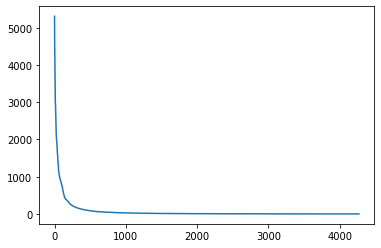

In [180]:
plt.plot(new_ans2['item'].value_counts().values)

## 유저군 분석을 위한 데이터 준비

In [74]:
### 데이터 준비
infer_df = numerize_for_infer(raw_data, profile2id, show2id)

loader = DataLoader(args.data)
n_items = loader.load_n_items()

n_users = infer_df['uid'].max() + 1

rows, cols = infer_df['uid'], infer_df['sid']
data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, n_items))

N = data.shape[0]
idxlist = list(range(N))

In [ ]:
with open(args.dae_save, 'rb') as f:
    model_dae = MultiDAE(p_dims).to(device)
    checkpoint = torch.load(f)
    model_dae.load_state_dict(checkpoint['state_dict'])

In [ ]:
with open(args.vae_save, 'rb') as f:
    model_vae = MultiVAE(p_dims).to(device)
    checkpoint = torch.load(f)
    model_vae.load_state_dict(checkpoint['state_dict'])

In [ ]:
criterion = loss_function_dae_genre
criterion2 = loss_function_vae_genre

In [ ]:
total_loss = 0
total_loss2 = 0
update_count = 0 #tmp

model_dae.eval()
model_vae.eval()
with torch.no_grad():
    data_tensor = naive_sparse2tensor(check_data_tr).to(device)
    data_tensor2 = naive_sparse2tensor(check_data_tr).to(device)

    if args.total_anneal_steps > 0:
        anneal = min(args.anneal_cap, 1. * update_count / args.total_anneal_steps)
    else:
        anneal = args.anneal_cap

    recon_genre, recon_title, dae_ori_output = model_dae(data_tensor)
    loss = criterion(recon_genre, recon_title, dae_ori_output, data_tensor)
    total_loss += loss.item()

    recon_genre2, recon_title2, vae_ori_output, mu, logvar = model_vae(data_tensor2)
    loss2 = criterion2(recon_genre2, recon_title2, vae_ori_output, data_tensor2, mu, logvar, anneal)
    total_loss2 += loss2.item()

    # Exclude examples from training set
    dae_ori_output = dae_ori_output.cpu().numpy()
    vae_ori_output = vae_ori_output.cpu().numpy()

    recon_genre = recon_genre.cpu().numpy()
    recon_genre2 = recon_genre2.cpu().numpy()

    recon_title = recon_title.cpu().numpy()
    recon_title2 = recon_title2.cpu().numpy()

    ensemble_output = np.add(dae_ori_output, vae_ori_output) # 1:1로 앙상블
    genre_add_ensemble_output = ensemble_output + np.mean(recon_genre)*10 + np.mean(recon_genre2)*10 + np.mean(recon_title)*10 + np.mean(recon_title2)*10

    genre_add_ensemble_output[check_data_tr.nonzero()] = -np.inf
    dae_ori_output[check_data_tr.nonzero()] = -np.inf
    vae_ori_output[check_data_tr.nonzero()] = -np.inf

    ensem_r10 = Recall_at_k_batch(genre_add_ensemble_output, check_data_te, 10)
    dae_r10 = Recall_at_k_batch(dae_ori_output, check_data_te, 10)
    vae_r10 = Recall_at_k_batch(vae_ori_output, check_data_te, 10)

    ensem_r30 = Recall_at_k_batch(genre_add_ensemble_output, check_data_te, 30)
    dae_r30 = Recall_at_k_batch(dae_ori_output, check_data_te, 30)
    vae_r30 = Recall_at_k_batch(vae_ori_output, check_data_te, 30)

    print('| ensem_r10 {:4.2f} | dae_r10 {:4.2f} | vae_r10 {:4.2f} | ensem_r30 {:4.2f} | '
        'dae_r30 {:4.2f} | vae_r30 {:4.2f} '.format(np.mean(ensem_r10), np.mean(dae_r10), np.mean(vae_r10),
         np.mean(ensem_r30), np.mean(dae_r30), np.mean(vae_r30)))

    ##Recall
    gen_emb_10_idx = bn.argpartition(-genre_add_ensemble_output, 10, axis=1)[:, :10]
    gen_emb_30_idx = bn.argpartition(-genre_add_ensemble_output, 30, axis=1)[:, :30]

    dae_ori_output_10_idx = bn.argpartition(-dae_ori_output, 10, axis=1)[:, :10]
    dae_ori_output_30_idx = bn.argpartition(-dae_ori_output, 30, axis=1)[:, :30]

    vae_ori_output_10_idx = bn.argpartition(-vae_ori_output, 10, axis=1)[:, :10]
    vae_ori_output_30_idx = bn.argpartition(-vae_ori_output, 30, axis=1)[:, :30]

In [ ]:
def output_to_dataframe(idx):
    user = []
    item = []
    if idx.shape[1] == 10:
        for i_idx, arr_10 in enumerate(idx):
            user.extend([i_idx]*10)
            item.extend(arr_10)
    else:
        for i_idx, arr_10 in enumerate(idx):
            user.extend([i_idx]*30)
            item.extend(arr_10)

    u = pd.DataFrame(user, columns=['user'])
    i = pd.DataFrame(item, columns=['item'])
    all = pd.concat([u, i], axis=1)

    re_p2id = dict((v, k) for k, v in profile2id.items())
    re_s2id = dict((v, k) for k, v in show2id.items())

    def de_numerize(tp, re_p2id, re_s2id):
        uid = tp['user'].apply(lambda x: re_p2id[x])
        sid = tp['item'].apply(lambda x: re_s2id[x])
        return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

    ans = de_numerize(all, re_p2id, re_s2id)
    ans.columns = ['user', 'item']
    new_ans = ans.sort_values('user')
    return new_ans

In [ ]:
gen_emb_10_result = output_to_dataframe(gen_emb_10_idx)
gen_emb_30_result = output_to_dataframe(gen_emb_30_idx)

dae_ori_output_10_result = output_to_dataframe(dae_ori_output_10_idx)
dae_ori_output_30_result = output_to_dataframe(dae_ori_output_30_idx)

vae_ori_output_10_result = output_to_dataframe(vae_ori_output_10_idx)
vae_ori_output_30_result = output_to_dataframe(vae_ori_output_30_idx)

In [ ]:
gen_emb_30_result

In [ ]:
gen_emb_10_result.to_csv('fin_gen_emb_10_result.csv', index=False)
gen_emb_30_result.to_csv('fin_gen_emb_30_result.csv', index=False)

dae_ori_output_10_result.to_csv('fin_dae_ori_output_10_result.csv', index=False)
dae_ori_output_30_result.to_csv('fin_dae_ori_output_30_result.csv', index=False)

vae_ori_output_10_result.to_csv('fin_vae_ori_output_10_result.csv', index=False)
vae_ori_output_30_result.to_csv('fin_vae_ori_output_30_result.csv', index=False)

In [ ]:
df = pd.DataFrame(check_data_te.toarray())

cols = df.columns.values
mask = df.gt(0.0).values
out = [cols[x].tolist() for x in mask]

In [ ]:
user = []
item = []

for i in range(len(out)):
    user.extend([i]*len(out[i]))
    item.extend(out[i])

u = pd.DataFrame(user, columns=['user'])
i = pd.DataFrame(item, columns=['item'])
all = pd.concat([u, i], axis=1)

re_p2id = dict((v, k) for k, v in profile2id.items())
re_s2id = dict((v, k) for k, v in show2id.items())

def de_numerize(tp, re_p2id, re_s2id):
    uid = tp['user'].apply(lambda x: re_p2id[x])
    sid = tp['item'].apply(lambda x: re_s2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

real_ans = de_numerize(all, re_p2id, re_s2id)
real_ans.columns = ['user', 'item']
real_new_ans = real_ans.sort_values('user')

In [ ]:
real_new_ans

In [ ]:
real_new_ans.to_csv('real_new_ans.csv', index=False)